<a href="https://colab.research.google.com/github/jeffheaton/stylegan2-toys/blob/master/morph_video_real.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Jeff Heaton](https://raw.githubusercontent.com/jeffheaton/present/master/images/github.jpg)

Copyright 2021 by [Jeff Heaton](https://www.youtube.com/channel/UCR1-GEpyOPzT2AO4D_eifdw), [released under Apache 2.0 license](https://github.com/jeffheaton/present/blob/master/LICENSE)
# StyleGAN2 Morph Between Two REAL Images

This notebook allows you to choose a starting and ending image and use StyleGAN2 to produce a "morph" video between the two pictures.  For the morph to work correctly, both images should be of human faces.  It helps if both pictures are cropped reasonably well to a square portrait to eliminate the possibility of two faces being present in one image.  The preprocessing code will lock in on the exact positioning of each image, so your crop does not have to be perfect. The main point of your crop is for you to remove anything else that might be confused for a face.  If multiple faces are detected, you will receive an error.

Also, make sure you have selected a GPU Runtime from CoLab. Choose "Runtime," then "Change Runtime Type," and choose GPU for "Hardware Accelerator."

The following YouTube video describes precisely how to run this notebook.

[Morphing Real Images to Video with StyleGAN2 ADA](http://youtube.com)

These settings allow you to change the high-level configuration.  The number of steps determines how long your resulting video is.  The video plays at 30 frames a second, so 150 is 5 seconds. You can also specify freeze steps to leave the video unchanged at the beginning and end. You will not likely need to change the network.


In [2]:
NETWORK = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
STEPS = 150
FPS = 30
FREEZE_STEPS = 30

# Upload Starting Image

Pilih gambar awal Anda.

In [3]:
import os
from google.colab import files

uploaded = files.upload()

if len(uploaded) != 1:
  print("Upload exactly 1 file for source.")
else:
  for k, v in uploaded.items():
    _, ext = os.path.splitext(k)
    os.remove(k)
    SOURCE_NAME = f"source{ext}"
    open(SOURCE_NAME, 'wb').write(v)

Saving download (3).jpg to download (3).jpg


Juga, pilih gambar akhir Anda.

In [4]:
uploaded = files.upload()

if len(uploaded) != 1:
  print("Upload exactly 1 file for target.")
else:
  for k, v in uploaded.items():
    _, ext = os.path.splitext(k)
    os.remove(k)
    TARGET_NAME = f"target{ext}"
    open(TARGET_NAME, 'wb').write(v)

Saving cute.jpg to cute.jpg


# Install Software

Perintah pertama mengunduh file dalam format bzip2, dan perintah kedua digunakan untuk mengekstrak file. sehingga dapat digunakan dalam tugas-tugas seperti pengenalan wajah atau penandaan landmark pada wajah dengan 5 titik.


In [5]:
!wget http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_5_face_landmarks.dat.bz2

--2023-12-08 06:20:50--  http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5706710 (5.4M)
Saving to: ‘shape_predictor_5_face_landmarks.dat.bz2’

shape_predictor_5_f 100%[===================>]   5.44M  14.8MB/s    in 0.4s    

2023-12-08 06:20:50 (14.8 MB/s) - ‘shape_predictor_5_face_landmarks.dat.bz2’ saved [5706710/5706710]

bzip2: Output file shape_predictor_5_face_landmarks.dat already exists.


pip install ninja digunakan untuk menginstal pustaka "ninja".path dari repositori yang telah diunduh ditambahkan ke path sistem menggunakan sys.path.insert()

In [6]:
import sys
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
!pip install ninja
sys.path.insert(0, "/content/stylegan2-ada-pytorch")

fatal: destination path 'stylegan2-ada-pytorch' already exists and is not an empty directory.


# Preprocess Images for Best StyleGAN Results

Berikut ini adalah fungsi pembantu untuk preprocessing.

mendeteksi dan mengekstrak gambar wajah dengan penekanan pada posisi mata. Fungsi find_eyes digunakan untuk menemukan posisi mata, sedangkan crop_stylegan menghasilkan gambar wajah yang diambil dengan penyesuaian ukuran dan pembatasan area sekitar mata.

In [7]:
import cv2
import numpy as np
from PIL import Image
import dlib

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_5_face_landmarks.dat')

def find_eyes(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  rects = detector(gray, 0)

  if len(rects) == 0:
    raise ValueError("No faces detected")
  elif len(rects) > 1:
    raise ValueError("Multiple faces detected")

  shape = predictor(gray, rects[0])
  features = []

  for i in range(0, 5):
    features.append((i, (shape.part(i).x, shape.part(i).y)))

  return (int(features[3][1][0] + features[2][1][0]) // 2, \
    int(features[3][1][1] + features[2][1][1]) // 2), \
    (int(features[1][1][0] + features[0][1][0]) // 2, \
    int(features[1][1][1] + features[0][1][1]) // 2)

def crop_stylegan(img):
  left_eye, right_eye = find_eyes(img)
  d = abs(right_eye[0] - left_eye[0])
  z = 255/d
  ar = img.shape[0]/img.shape[1]
  w = img.shape[1] * z
  img2 = cv2.resize(img, (int(w), int(w*ar)))
  bordersize = 1024
  img3 = cv2.copyMakeBorder(
      img2,
      top=bordersize,
      bottom=bordersize,
      left=bordersize,
      right=bordersize,
      borderType=cv2.BORDER_REPLICATE)

  left_eye2, right_eye2 = find_eyes(img3)

  crop1 = left_eye2[0] - 385
  crop0 = left_eye2[1] - 490
  return img3[crop0:crop0+1024,crop1:crop1+1024]

The following will preprocess and crop your images.  If you receive an error indicating multiple faces were found, try to crop your image better or obscure the background.  If the program does not see a face, then attempt to obtain a clearer and more high-resolution image.

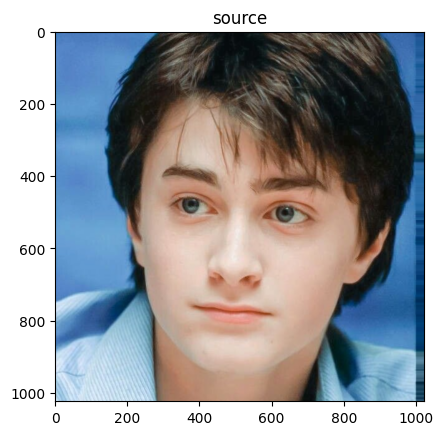

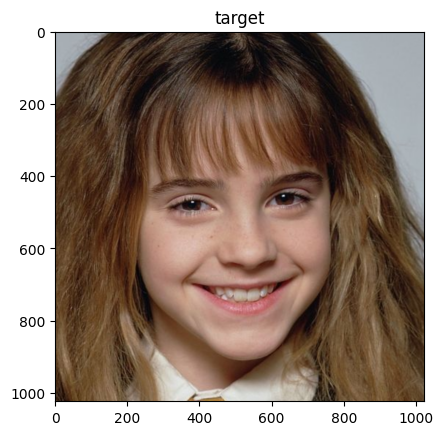

True

In [8]:
from matplotlib import pyplot as plt
import cv2

image_source = cv2.imread(SOURCE_NAME)
if image_source is None:
    raise ValueError("Source image not found")

image_target = cv2.imread(TARGET_NAME)
if image_target is None:
    raise ValueError("Source image not found")

cropped_source = crop_stylegan(image_source)
cropped_target = crop_stylegan(image_target)

img = cv2.cvtColor(cropped_source, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('source')
plt.show()

img = cv2.cvtColor(cropped_target, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('target')
plt.show()

cv2.imwrite("cropped_source.png", cropped_source)
cv2.imwrite("cropped_target.png", cropped_target)

#print(find_eyes(cropped_source))
#print(find_eyes(cropped_target))

# Convert Source to a GAN

Pertama, kita ubah sumbernya menjadi vektor laten GAN. Proses ini akan memakan waktu beberapa menit.

In [9]:
cmd = f"python /content/stylegan2-ada-pytorch/projector.py --save-video 0 --num-steps 1000 --outdir=out_source --target=cropped_source.png --network={NETWORK}"
!{cmd}

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
step    1/1000: dist 0.66 loss 24567.33
step    2/1000: dist 0.71 loss 27640.69
step    3/1000: dist 0.64 loss 27166.76
step    4/1000: dist 0.60 loss 26253.40
step    5/1000: dist 0.61 loss 24957.22
step    6/1000: dist 0.62 loss 23352.16
step    7/1000: dist 0.59 loss 21510.74
step    8/1000: dist 0.59 loss 19486.87
step    9/1000: dist 0.60 loss 17341.54
step   10/1000: dist 0.59 loss 15140.37
step   11/1000: dist 0.56 loss 12947.07
step   12/1000: dist 0.52 loss 10818.09
step   13/1000: dist 0.55 loss 8801.26
step   14/1000: dist 0.53 loss 6946.57
step   15/1000: dist 0.53 loss 5313.84
step   16/1000: dist 0.53 loss 3971.62
step   17/1000: dist 0.49 loss 2942.50
step   18/1000: dist 0.56 loss 2211.00
step   19/1000: dist 0

# Convert Target to a GAN

kode ini digunakan untuk menjalankan proyektor StyleGAN2-ADA pada gambar target yang telah di-crop, dengan hasil pemetaan disimpan di direktori "out_target".

In [10]:
cmd = f"python /content/stylegan2-ada-pytorch/projector.py --save-video 0 --num-steps 1000 --outdir=out_target --target=cropped_target.png --network={NETWORK}"
!{cmd}

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
step    1/1000: dist 0.62 loss 24567.28
step    2/1000: dist 0.65 loss 27640.62
step    3/1000: dist 0.58 loss 27166.69
step    4/1000: dist 0.62 loss 26253.42
step    5/1000: dist 0.62 loss 24957.23
step    6/1000: dist 0.59 loss 23352.13
step    7/1000: dist 0.60 loss 21510.75
step    8/1000: dist 0.56 loss 19486.83
step    9/1000: dist 0.57 loss 17341.51
step   10/1000: dist 0.55 loss 15140.33
step   11/1000: dist 0.50 loss 12947.02
step   12/1000: dist 0.56 loss 10818.12
step   13/1000: dist 0.55 loss 8801.26
step   14/1000: dist 0.51 loss 6946.55
step   15/1000: dist 0.51 loss 5313.82
step   16/1000: dist 0.49 loss 3971.58
step   17/1000: dist 0.51 loss 2942.51
step   18/1000: dist 0.52 loss 2210.95
step   19/1000: dist 0

With the conversion complete, lets have a look at the two GANs.

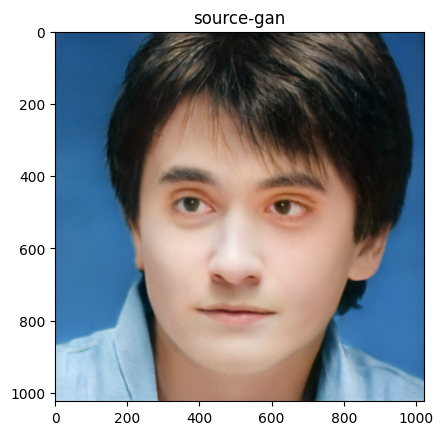

In [11]:
img_gan_source = cv2.imread('/content/out_source/proj.png')
img = cv2.cvtColor(img_gan_source, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('source-gan')
plt.show()

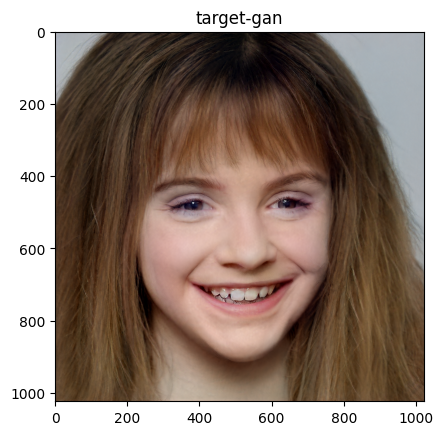

In [12]:
img_gan_target = cv2.imread('/content/out_target/proj.png')
img = cv2.cvtColor(img_gan_target, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('target-gan')
plt.show()

# Build the Video

Kode berikut membuat video transisi antara dua vektor laten yang diperoleh sebelumnya. Setelah konversi selesai, mari kita lihat kedua GAN.

In [13]:
import torch
import dnnlib
import legacy
import PIL.Image
import numpy as np
import imageio
from tqdm.notebook import tqdm

lvec1 = np.load('/content/out_source/projected_w.npz')['w']
lvec2 = np.load('/content/out_target/projected_w.npz')['w']

network_pkl = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as fp:
    G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore

diff = lvec2 - lvec1
step = diff / STEPS
current = lvec1.copy()
target_uint8 = np.array([1024,1024,3], dtype=np.uint8)

video = imageio.get_writer('/content/movie.mp4', mode='I', fps=FPS, codec='libx264', bitrate='16M')

for j in tqdm(range(STEPS)):
  z = torch.from_numpy(current).to(device)
  synth_image = G.synthesis(z, noise_mode='const')
  synth_image = (synth_image + 1) * (255/2)
  synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()

  repeat = FREEZE_STEPS if j==0 or j==(STEPS-1) else 1

  for i in range(repeat):
    video.append_data(synth_image)
  current = current + step


video.close()

  0%|          | 0/150 [00:00<?, ?it/s]

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


# Download your Video

If you made it through all of these steps, you are now ready to download your video.

In [14]:
from google.colab import files
files.download("movie.mp4")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>